In [3]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import igl
import numpy as np
import scipy as sp
from meshplot import plot, subplot, interact
from scipy.sparse.linalg import spsolve
import meshplot
import os
import math
import meshzoo

In [3]:
import time
#time

class tictoc:
    def __init__(self):
        self.prev = 0
        self.curr = 0
    def tic(self):
        self.prev = time.time()
    def toc(self):
        self.curr = time.time()
        print("dt(s) = %.3g" %(self.curr - self.prev))
        t = self.curr - self.prev
        self.prev = self.curr
        return t

tt = tictoc()
    


In [4]:
# finding center
def center(points):
   sum = [0,0,0]
   for i in points:
       sum += i
   x = sum/len(points)
   return x


In [8]:
points, cells= meshzoo.tube(length = 2, radius = 1.19, n = 165)
#points, cells = meshzoo.uv_sphere(num_points_per_circle=100, num_circles=30, radius=1)
p = subplot(points, cells, shading={"wireframe": False}, s=[1,4,0])

6600


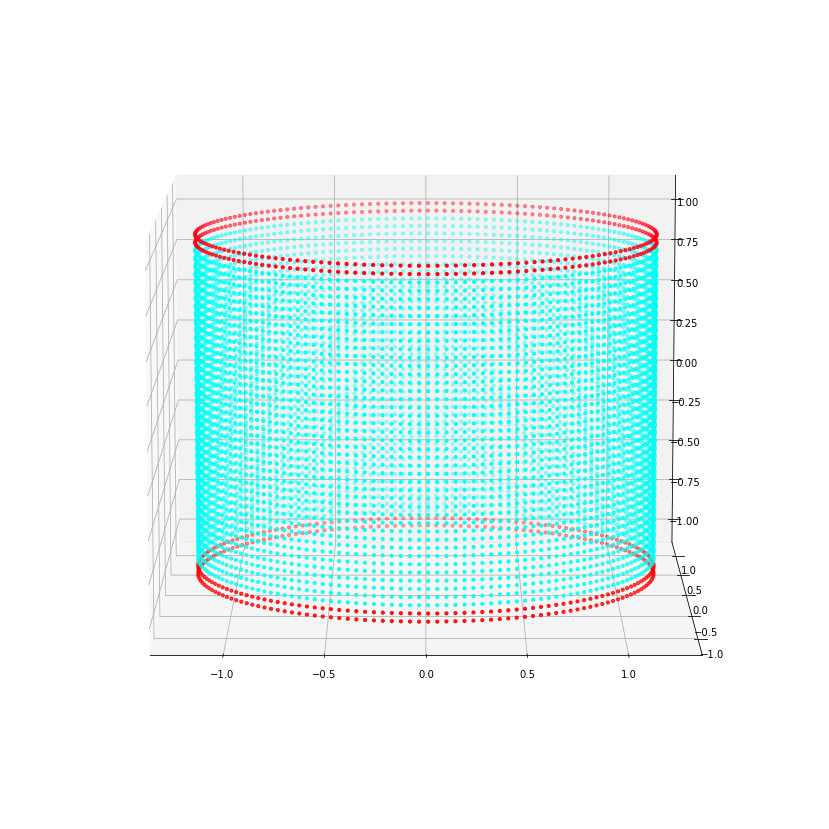

In [9]:
v = points

f1_id = []
f2_id = []

color = []

#finding boundary

def normalVector(phi, theta):
    x = math.sin(phi) * math.cos(theta)
    y = math.sin(phi) * math.sin(theta)
    z = math.cos(phi)
    norm = [x,y,z]
    return norm

def dotProduct(vec1, vec2):
    a = 0
    for i in range(len(vec1)):
        a += vec1[i]*vec2[i]
    return a

def angle(norm, vector, givAng):
    a = dotProduct(norm,vector)
    len1 = math.sqrt(dotProduct(norm, norm))
    len2 = math.sqrt(dotProduct(vector, vector))
    b = a/(len1*len2)
    if b>1:
        b = 1
    elif b<-1:
        b = -1
    else:
        ang = math.acos(b)
    return ang<=givAng

#main

norm1 = normalVector(math.pi/2, 2*math.pi/3)
norm2 = normalVector(math.pi/2, -2*math.pi/3)
norm3 = normalVector(math.pi/2, 0)
for i in range(len(v)):
    if v[i][2] > 0.95:
        color += [2]
        f1_id += [i]
    else:
        if v[i][2] < -0.95 :
            color += [-2]
            f2_id += [i]
        else:
            color += [0]

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], s = 10 , c=color, cmap='hsv'); #, cmap='hsv' )

ax.view_init(10,-90)
freePoint = len(v)-len(f1_id)-len(f2_id)
print(freePoint)
plt.show()

c:\Users\User\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Users\User\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


dt(s) = 36.3
11


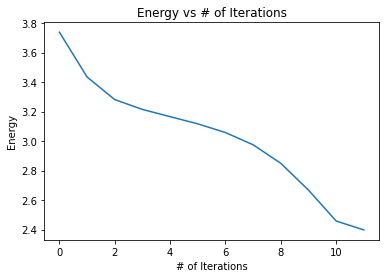

In [10]:


#root_folder = r"C:\Users\User\Desktop"

#v, f = igl.read_triangle_mesh(os.path.join(root_folder, "cylinder.ply"))

vs = [v]
es = []

l = -1/8*igl.cotmatrix(vs[0],cells)
vt = np.transpose(vs[0])
es.append(vt.dot(l.dot(vs[0])).trace())

#minimization
def miniQ(l,v,f1,f2):
    lt = np.transpose(l)
    boundV = []
    boundLt = []
    nonBoundLt = []
    nonBoundL2 = []
    for i in range(v.shape[0]):
        if i in f1 or i in f2:
            boundV.append(v[i])
            boundLt.append(lt[i])
        else:
            nonBoundLt.append(lt[i])

    boundL = np.transpose(boundLt)
    nonBoundL = np.transpose(nonBoundLt)

    for i in range(v.shape[0]):
        if i not in f1 and i not in f2:
            nonBoundL2.append(nonBoundL[i])
    b = -boundL.dot(boundV)
    b2 = []
    for i in range(v.shape[0]):
        if i not in f1 and i not in f2:
            b2.append(b[i])
    x = spsolve(nonBoundL2, b2)
    final = []
    temp = 0
    for i in range(v.shape[0]):
        if i in f1 or i in f2:
            final.append(v[i])
        else:
            final.append(x[temp])
            temp+=1
    return np.asarray(final)


tt.tic()
#main code
for i in range(30):
    l = -1/8*igl.cotmatrix(vs[i],cells).toarray()

    Q = miniQ(l,vs[i],f1_id,f2_id)
    vs.append(Q)

    # energy 
    vt = np.transpose(vs[i+1])
    es.append(vt.dot(l.dot(vs[i+1])).trace())

tt.toc()
es=[ i for i in es if not(math.isnan(i)==True)]

plt.plot(es)
plt.title("Energy vs # of Iterations")
plt.xlabel("# of Iterations")
plt.ylabel("Energy")


lastidx = len(es)-1
print(lastidx)
p = subplot(vs[0], cells, shading={"wireframe": False}, s=[1,4,0])
subplot(vs[1], cells, shading={"wireframe": False}, s=[1,4,1], data=p)
subplot(vs[2], cells, shading={"wireframe": False}, s=[1,4,2], data=p)
subplot(vs[lastidx], cells, shading={"wireframe": False}, s=[1,4,3], data=p)


In [11]:
E = []
VS = []
CELL = []


In [125]:
E.append(es[lastidx])
VS.append(vs[lastidx])
CELL.append(cells)

In [127]:
R = []

In [128]:
import sys


radius = sys.maxsize
for i in VS:
    for j in i:
        temp = math.sqrt(j[0]**2+j[1]**2)
        if(temp<radius):
            radius = temp
    R.append(radius)
    radius = sys.maxsize


In [129]:
area = []
for i in R:
    a = i**2 * math.pi
    area.append(a)

area


[1.777307077217945e-30,
 2.148629775059331,
 3.9853200629568115,
 5.262667521108653,
 2.952130449726535e-27,
 9.984351609369259e-28,
 9.523641921549838e-30,
 5.849708892819974e-28]

Text(0.5, 1.0, 'tude')

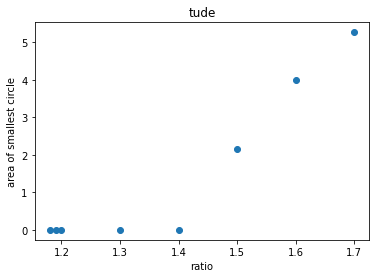

In [166]:
x=[1.4,  1.5,  1.6,  1.7,  1.3,  1.2,  1.18,  1.19]
x.sort()
area.sort()

plt.scatter(x,area)
plt.ylabel("area of smallest circle")
plt.xlabel("ratio")
plt.title("tude")

In [126]:
p = subplot(VS[3], CELL[3], shading={"wireframe": False}, s=[1,4,0])
print(len(VS))

8


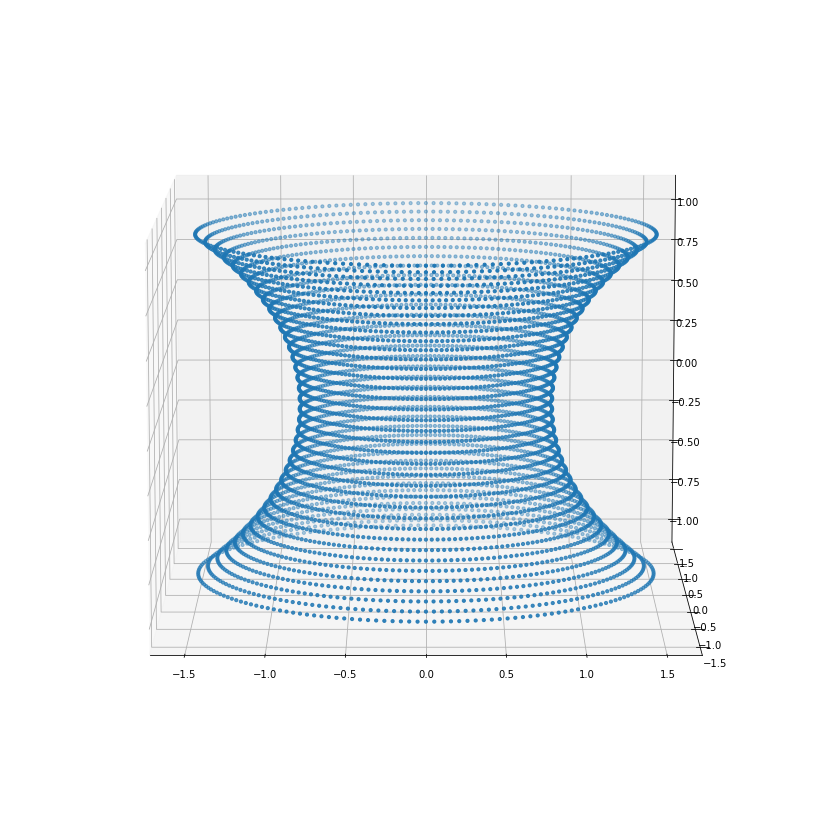

In [57]:
SES = []
SVS = []
SCELL = []